In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from darts import TimeSeries

df = pd.read_csv('../csv/Ming1Jul67_total_order.csv')
df.tail()

,order_completed_at,unique_order_count
543,2024-06-27,145
544,2024-06-28,142
545,2024-06-29,126
546,2024-06-30,161
547,2024-07-01,142


In [3]:
df.head()

,order_completed_at,unique_order_count
0,2023-01-01,15
1,2023-01-02,32
2,2023-01-03,89
3,2023-01-04,73
4,2023-01-05,67


In [4]:
df.shape

(548, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_completed_at  541 non-null    object
 1   unique_order_count  541 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.6+ KB


In [5]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])
# make timeseries Object
series = TimeSeries.from_dataframe(df,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")

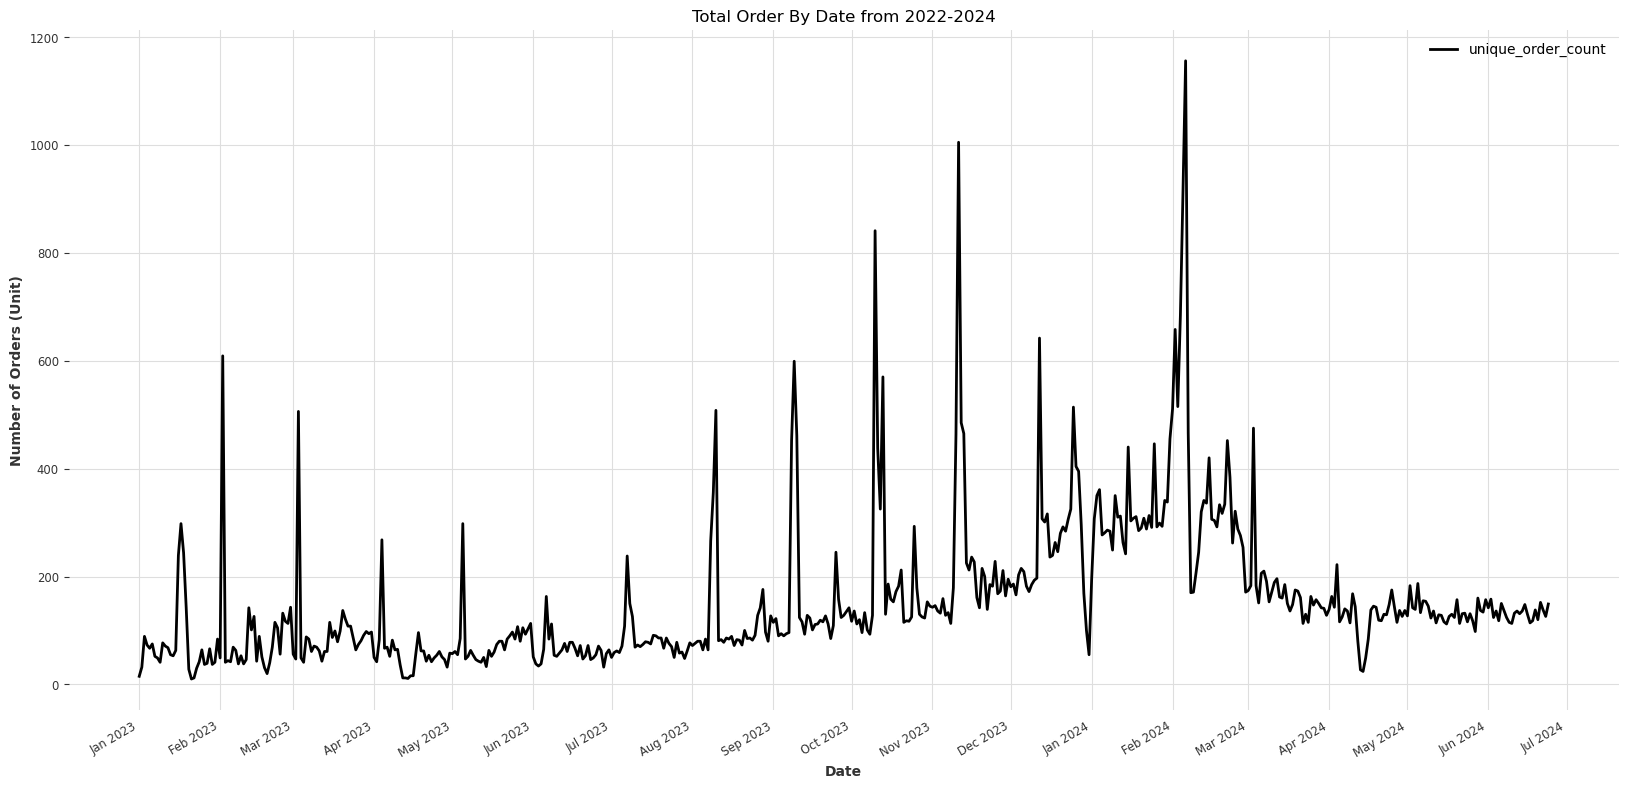

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10)) 
series.plot()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate() 

plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

In [6]:
# Function to replace outliers with the mean of the rest of the values
from scipy.stats import zscore
from darts import TimeSeries

def replace_outliers_with_mean(df, column_name):
    # Calculate Z-scores
    z_scores = zscore(df[column_name])
    
    # Identify outliers (using a threshold of 3 for Z-score)
    outliers = np.abs(z_scores) > 3
    
    # Calculate mean of non-outliers
    mean_non_outliers = df.loc[~outliers, column_name].mean()
    
    # Replace outliers with the mean of non-outliers
    df.loc[outliers, column_name] = mean_non_outliers
    
    return df

# Replace outliers in 'gmv' column
df_remove_out = replace_outliers_with_mean(df, 'unique_order_count')
series_remove_outlier = TimeSeries.from_dataframe(df_remove_out,
                                   time_col='order_completed_at',
                                   value_cols=['unique_order_count'],
                                   freq="D")
series = series_remove_outlier

C:\Users\User\AppData\Local\Temp\ipykernel_30628\1351848665.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '142.51486988847583' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[outliers, column_name] = mean_non_outliers


In [24]:
# from darts.dataprocessing.transformers import (Scaler,)

# scaler = Scaler()
# series = series_remove_outlier #!!!
# series_rescaled = scaler.fit_transform(series)

In [7]:
# series = series_rescaled
cut_off  = pd.Timestamp('2024-05-01')
training, validation =series.split_before(cut_off)
# training, validation =series.split_before(pd.Timestamp('2024-05-01')) # 1 month
# training, validation =series.split_before(pd.Timestamp('2024-04-01')) # 2 month

validation_df = validation.pd_dataframe()
training_df = training.pd_dataframe()
print(training_df.tail())
print(validation_df.head())

component           unique_order_count
order_completed_at                    
2024-04-26                       144.0
2024-04-27                       115.0
2024-04-28                       137.0
2024-04-29                       126.0
2024-04-30                       137.0
component           unique_order_count
order_completed_at                    
2024-05-01                       127.0
2024-05-02                       183.0
2024-05-03                       142.0
2024-05-04                       139.0
2024-05-05                       187.0


In [8]:
print(training_df.shape)
print(validation_df.shape)

(486, 1)
(62, 1)


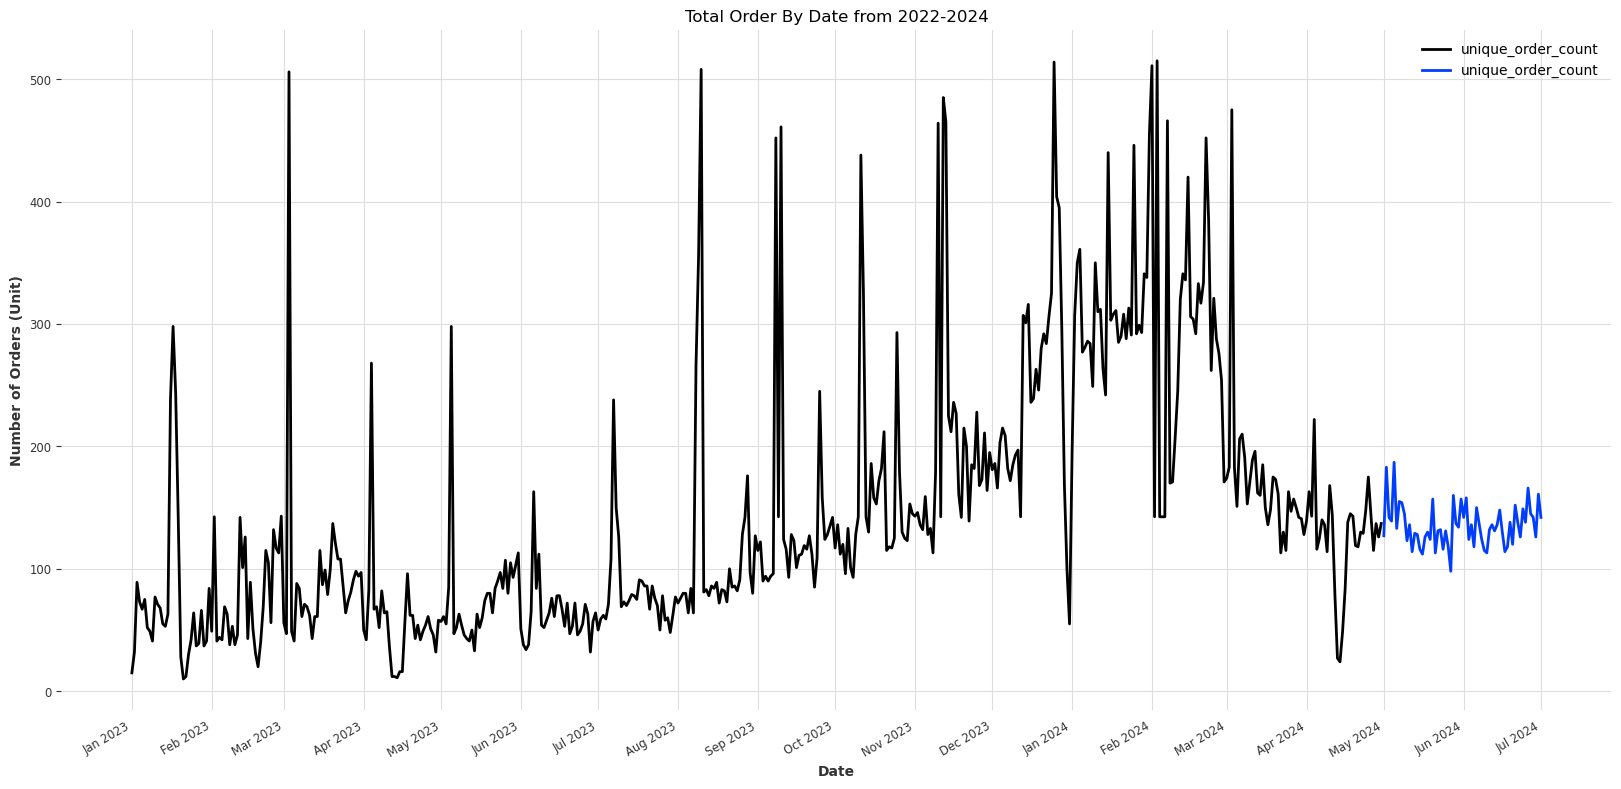

In [9]:
import matplotlib.dates as mdates

plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
training.plot()
validation.plot()

# ตั้งค่ารูปแบบของวันที่บนแกน x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()  # ปรับให้วันที่ไม่ซ้อนกัน

# กำหนด Title และชื่อของแกน x และ y
plt.title('Total Order By Date from 2022-2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders (Unit)')

plt.show()

In [51]:
# from darts.models import ExponentialSmoothing

# model = ExponentialSmoothing(

#     random_state=42
# )
# model.fit(training)
# forecast = model.predict(len(validation))

In [10]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.models import ExponentialSmoothing

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsforecast\utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [36]:
parameters = {
    "trend":[ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE],
    "seasonal": [SeasonalityMode.ADDITIVE, SeasonalityMode.MULTIPLICATIVE],
    'seasonal_periods': list(range(2,31)),
    "random_state": [42]
}

best_parameter = ExponentialSmoothing.gridsearch(
    parameters=parameters,
    series = series, #note (training + validation) X only training set!!!
    start=cut_off,
    forecast_horizon=7,
    stride=1,          
    last_points_only=False,  
    metric=mse,
    verbose=-1
)

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


  0%|          | 0/103 [00:00<?, ?it/s]

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ er

In [12]:
best_model = ExponentialSmoothing(
    trend=ModelMode.ADDITIVE, 
    seasonal=SeasonalityMode.MULTIPLICATIVE, 
    seasonal_periods=3, 
    random_state= 42
)
best_model.fit(training)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.MULTIPLICATIVE, seasonal_periods=3, random_state=42, kwargs=None)

In [41]:
print(best_parameter)

(ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.MULTIPLICATIVE, seasonal_periods=7, random_state=42, kwargs=None), {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal_periods': 7, 'random_state': 42}, 974.8487297207083)


In [42]:
best_model = best_parameter[0]
best_model.fit(training)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.MULTIPLICATIVE, seasonal_periods=7, random_state=42, kwargs=None)

In [13]:
# result from training , validation only
prediction = best_model.predict(len(validation))

mape_score = mape(validation, prediction)
print(f'score MAPE: {round(mape_score, 4)}')
print(f'score ACC: {100-(round(mape_score, 4))}')

mse_score = mse(validation, prediction)
print(f'score MSE: {round(mse_score, 4)}')

print(f'score RMSE: {round(sqrt(mse_score), 4)}')

mae_score = mae(validation, prediction)
print(f'score MAE: {round(mae_score, 4)}')

score MAPE: 9.3024
score ACC: 90.6976
score MSE: 285.8138
score RMSE: 16.906
score MAE: 12.9632


In [ ]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt

backtest_errors = best_model.backtest(
     series,
     start=0.8,          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mape,
     reduction=np.mean,           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
     verbose=-1
)
print(f'backtest_errors MAPE: {backtest_errors}')

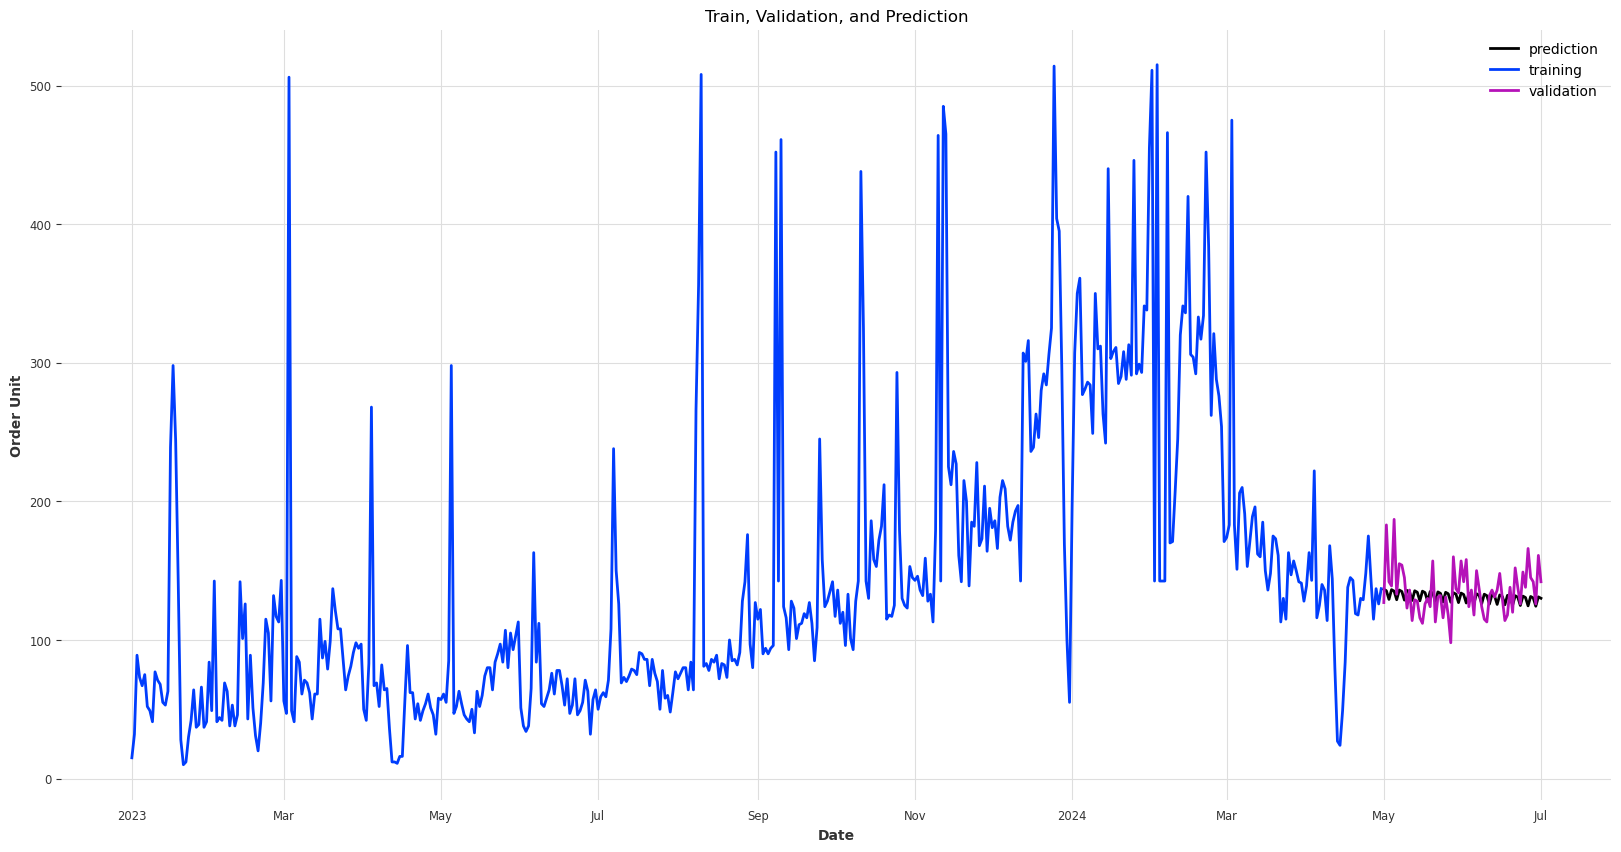

In [14]:
plt.figure(figsize=(20, 10))  # ปรับขนาดของภาพ (กว้าง x สูง)
##prediction
prediction.plot(label="prediction")
training.plot(label="training")
validation.plot(label="validation")

plt.legend()
plt.title('Train, Validation, and Prediction')
plt.xlabel('Date')
plt.ylabel('Order Unit')
plt.show()

In [15]:
# predict future
best_model.fit(series)

ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.MULTIPLICATIVE, seasonal_periods=3, random_state=42, kwargs=None)

In [16]:
#check date
series.pd_dataframe().tail(14)

component,unique_order_count
order_completed_at,
2024-06-18,118.0
2024-06-19,138.0
2024-06-20,120.0
2024-06-21,152.0
2024-06-22,138.0
2024-06-23,126.0
2024-06-24,149.0
2024-06-25,138.0
2024-06-26,166.0


In [17]:
forecast = best_model.predict(7)
# forecast  = scaler.inverse_transform(forecast)
forecast = forecast.pd_dataframe().reset_index()
forecast.columns = ['Date', 'Total Order']
print(forecast.tail(7))

forecast.tail(7).to_csv('../forecast/Date_ExponentialSmoothing_1month.csv', index=False)

        Date  Total Order
0 2024-07-02   136.910840
1 2024-07-03   145.941207
2 2024-07-04   145.285583
3 2024-07-05   136.675410
4 2024-07-06   145.690104
5 2024-07-07   145.035465
6 2024-07-08   136.439980


In [18]:
best_model.save("../model/Exponential_Smoothing_totalOrder_1Jul67.pkl")

In [27]:
from darts.metrics import mape, mae, mse, mase
from math import sqrt
from darts.models import ExponentialSmoothing

training, validation =series.split_before(pd.Timestamp('2024-05-01')) # 1 month

best_model = ExponentialSmoothing.load("../model_old/exponentialSmooth/Exponential_Smoothing_totalOrder_25Jun67.pkl")
backtest_errors = best_model.backtest(
     series,
     start=pd.Timestamp('2024-05-01'),          # เริ่มต้นที่ 90% ของข้อมูล
     forecast_horizon=7, #จำนวนก้าวการพยากรณ์ในอนาคตที่ต้องการ
     stride=1,           #ช่วงการเลื่อนในการทดสอบแต่ละครั้ง
     last_points_only=False,  #  ให้แสดงเฉพาะจุดสิ้นสุดของการพยากรณ์หรือไม่
     metric=mse,
     reduction=np.mean           #ฟังก์ชันการลดรูปผลลัพธ์ (เช่น mean การหาเฉลี่ย)
)
print(f'backtest_errors MSE: {backtest_errors}')

backtest_errors MSE: 363.2850511628273
